In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
import joblib

sns.set(style="whitegrid", context="notebook")
pd.set_option("display.max_columns", 120)

In [47]:
DATA_PATH = "new-york-listings.csv"

df_raw = pd.read_csv(DATA_PATH)
df = df_raw.copy()
print("Shape:", df_raw.shape)
df_raw.head()

Shape: (36111, 79)


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,estimated_revenue_l365d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,40824219,https://www.airbnb.com/rooms/40824219,2.025100e+13,2025-10-02,city scrape,Room close to Manhattan for FEMALE guests,This cozy spacious room includes a twin size b...,Sunnyside is a safe residental area. <br />The...,https://a0.muscache.com/pictures/hosting/Hosti...,317540555,https://www.airbnb.com/users/show/317540555,Sevil,2019-12-14,NaN,NaN,within a few hours,100%,54%,t,https://a0.muscache.com/im/pictures/user/771f9...,https://a0.muscache.com/im/pictures/user/771f9...,Sunnyside,3.0,3.0,"['email', 'phone']",t,t,Neighborhood highlights,Sunnyside,Queens,40.74698,-73.91763,Private room in townhouse,Private room,1,1.0,1 shared bath,1.0,1.0,"[""Extra pillows and blankets"", ""Dedicated work...",$66.00,30,365,30.0,30.0,365.0,365.0,30.0,365.0,NaN,t,16,46,76,77,2025-10-02,16,2,0,77,0,120,7920.0,2019-12-25,2025-08-06,4.81,4.81,4.88,4.81,4.88,4.94,4.69,NaN,f,3,0,3,0,0.23
1,40833186,https://www.airbnb.com/rooms/40833186,2.025100e+13,2025-10-02,previous scrape,Soho LES East village private room downtown,NaN,NaN,https://a0.muscache.com/pictures/1f093bbc-936c...,68718914,https://www.airbnb.com/users/show/68718914,Patricio,2016-04-24,NaN,NaN,NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/0b4f9...,https://a0.muscache.com/im/pictures/user/0b4f9...,NaN,1.0,1.0,['phone'],t,t,NaN,Nolita,Manhattan,40.72314,-73.99323,Private room in serviced apartment,Private room,2,NaN,1 shared bath,1.0,NaN,"[""Hot water"", ""Air conditioning"", ""Wifi"", ""TV""...",NaN,30,1125,30.0,30.0,1125.0,1125.0,30.0,1125.0,NaN,t,0,0,0,0,2025-10-02,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,1,0,1,0,NaN
2,40837137,https://www.airbnb.com/rooms/40837137,2.025100e+13,2025-10-02,previous scrape,Sunset Park - Quiet and close to subway!,"Cozy, lovely bedroom with a comfortable full s...",the sunset park of Brooklyn,https://a0.muscache.com/pictures/01c4e91e-4012...,317770098,https://www.airbnb.com/users/show/317770098,Xuan,2019-12-15,"New York, United States",NaN,NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/2c4b1...,https://a0.muscache.com/im/pictures/user/2c4b1...,Sunset Park,1.0,1.0,"['email', 'phone']",t,t,Neighborhood highlights,Sunset Park,Brooklyn,40.64607,-74.00552,Private room in home,Private room,1,NaN,1 shared bath,NaN,NaN,"[""Smoke alarm"", ""Kitchen"", ""Hair dryer"", ""Wifi...",NaN,30,180,30.0,30.0,180.0,180.0,30.0,180.0,NaN,NaN,0,0,0,0,2025-10-02,1,0,0,0,0,0,NaN,2020-01-19,2020-01-19,5.00,5.00,4.00,5.00,5.00,5.00,5.00,NaN,f,1,0,1,0,0.01
3,40838018,https://www.airbnb.com/rooms/40838018,2.025100e+13,2025-10-02,previous scrape,Cozy One Bedroo

In [48]:
print("\nColumns:")
print(df_raw.columns.tolist())

print("\nData Types:")
print(df_raw.dtypes)

print("\nMissing values (top 30):")
print(df_raw.isna().sum().sort_values(ascending=False).head(30))


Columns:
['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 

In [49]:
#convert airbnb-style price strings like $1230.00 to float
def clean_price_series(s:pd.Series) -> pd.Series:
    return (
        s.astype(str)
        .str.replace(r"[\$,]", "", regex=True)
        .str.strip()
        .replace("", np.nan)
        .astype(float)
    )

In [50]:
# Identify potential leakage features
leakage_features = {"estimated_revenue_l365d", "estimated_occupancy_l365d","calculated_host_listings_count_entire_homes","calculated_host_listings_count_private_rooms","calculated_host_listings_count_shared_rooms", "calculated_host_listings_count","license", "neighbourhood"}
#drop leakage features
drop_cols = [c for c in leakage_features if c in df.columns]
if drop_cols:
    df = df.drop(columns=drop_cols)
    print("\nDropped leakage columns:", drop_cols)


Dropped leakage columns: ['calculated_host_listings_count_private_rooms', 'estimated_revenue_l365d', 'estimated_occupancy_l365d', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_shared_rooms']

Dropped useless columns: ['neighbourhood', 'license']


In [51]:
#clean price column with function from previous cell
df["price"] = clean_price_series(df["price"])
#identify date columns
date_cols = ["last_scraped","calendar_last_scraped","first_review","last_review","host_since"]
#convert to datetime
for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors="coerce")

#one-hot encode boolean-like columns
bool_like_cols = [
    "host_is_superhost",
    "host_has_profile_pic",
    "host_identity_verified",
    "has_availability",
    "instant_bookable"
]

for col in bool_like_cols:
    if col in df.columns:
        df[col] = df[col].map({"t": 1, "f": 0}).astype("float")

In [52]:
# Filter out listings with missing or zero price
df = df[df["price"].notna() & (df["price"] > 0)]
# Filter price to 1st-97th percentiles to remove extreme outliers
q_low, q_high = df["price"].quantile([0.01, 0.97])
df = df[(df["price"] >= q_low) & (df["price"] <= q_high)]

print("\nTop 30 missing values after dropping data missing price and filtering percentile")
print(df.isna().sum().sort_values(ascending=False).head(30))

print("\nShape after price filtering:", df.shape)
df["price"].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])


Top 30 missing values after dropping data missing price and filtering percentile
calendar_updated               20477
neighborhood_overview          10085
host_about                      8944
first_review                    5884
last_review                     5884
review_scores_rating            5884
review_scores_communication     5884
reviews_per_month               5884
review_scores_value             5884
review_scores_cleanliness       5884
review_scores_accuracy          5884
review_scores_checkin           5884
review_scores_location          5884
host_location                   5623
host_neighbourhood              5134
host_acceptance_rate            4215
host_response_time              4060
host_response_rate              4060
host_picture_url                1034
host_identity_verified          1034
host_thumbnail_url              1034
host_listings_count             1034
host_name                       1034
host_verifications              1034
host_has_profile_pic          

count    20477.000000
mean       202.877912
std        160.332896
min         37.000000
10%         56.000000
25%         89.000000
50%        150.000000
75%        261.000000
90%        427.000000
max        950.000000
Name: price, dtype: float64

In [53]:
#Feature engineering - amenities count, host tenure days, text lengths
#Create amenities_count feature
df ["amenities_count"] = (
    df["amenities"]
    .fillna("")
    .astype(str)
    .str.strip("{}")
    .str.count(",") + 1
)
df.loc[df["amenities"] == "", "amenities_count"] = 0
#Create host_tenure_days feature
if {"host_since", "last_scraped"}.issubset(df.columns):
    df["host_tenure_days"] = (
        (df["last_scraped"] - df["host_since"])
        .dt.days
    )

else:
    df["host_tenure_days"] = np.nan

print("\nListings with zero amenities:", (df["amenities_count"] == 0).sum())
# Create text length features
df["name_len"] = df["name"].fillna("").astype(str).str.len()
df["description_len"] = df["description"].fillna("").astype(str).str.len() 
df["neighborhood_overview_len"] = df["neighborhood_overview"].fillna("").astype(str).str.len()

df[["price", "amenities_count", "host_tenure_days", "name_len", "description_len"]].head()






Listings with zero amenities: 0


,price,amenities_count,host_tenure_days,name_len,description_len
0,66.0,29,2119.0,42,202
4,76.0,37,4639.0,41,380
5,97.0,14,2207.0,48,499
7,60.0,27,4174.0,25,193
8,425.0,61,4452.0,44,481


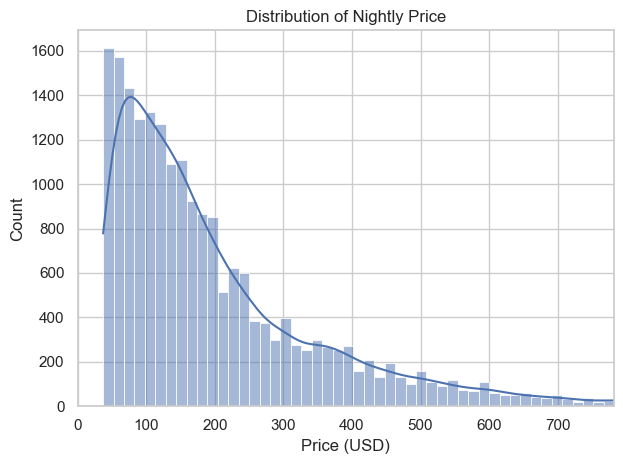

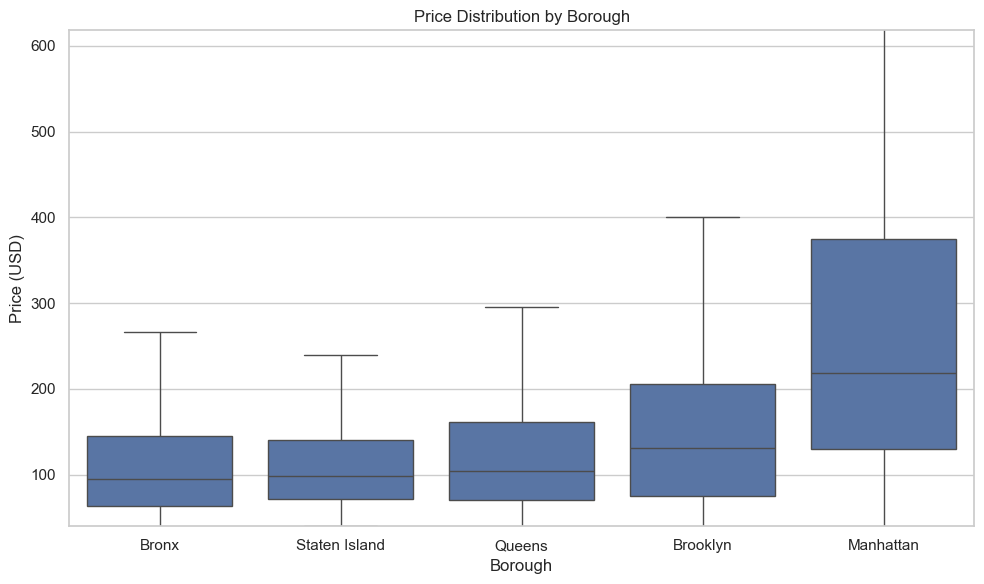

In [70]:
# Exploratory Data Analysis (EDA)
p99 = df['price'].quantile(0.97)
sns.histplot(df['price'], bins=60, kde=True)
plt.xlim(0, p99)
plt.title('Distribution of Nightly Price')
plt.xlabel('Price (USD)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

if "neighbourhood_group_cleansed" in df.columns:
    plt.figure(figsize=(10,6))
    order = (
    df.groupby("neighbourhood_group_cleansed")["price"]
    .median()
    .sort_values()
    .index
    )

    sns.boxplot(
    data=df,
    x='neighbourhood_group_cleansed',
    y='price',
    order=order,
    showfliers=False
    )
    # Limit y-axis to 1st-97th percentiles for comparability
    y_low = df['price'].quantile(0.01)
    y_high = df['price'].quantile(0.97)
    plt.ylim(y_low, y_high)
    plt.title('Price Distribution by Borough')
    plt.xlabel('Borough')
    plt.ylabel('Price (USD)')
    plt.tight_layout()
    plt.show()

Borough-level price summary:
                              count        mean  median         std
neighbourhood_group_cleansed                                       
Bronx                           805  116.744099    95.0   84.945822
Staten Island                   305  119.104918    99.0   84.898326
Queens                         3245  133.155008   104.0   96.180348
Brooklyn                       7315  165.028298   131.0  127.552391
Manhattan                      8807  270.779494   219.0  182.843062


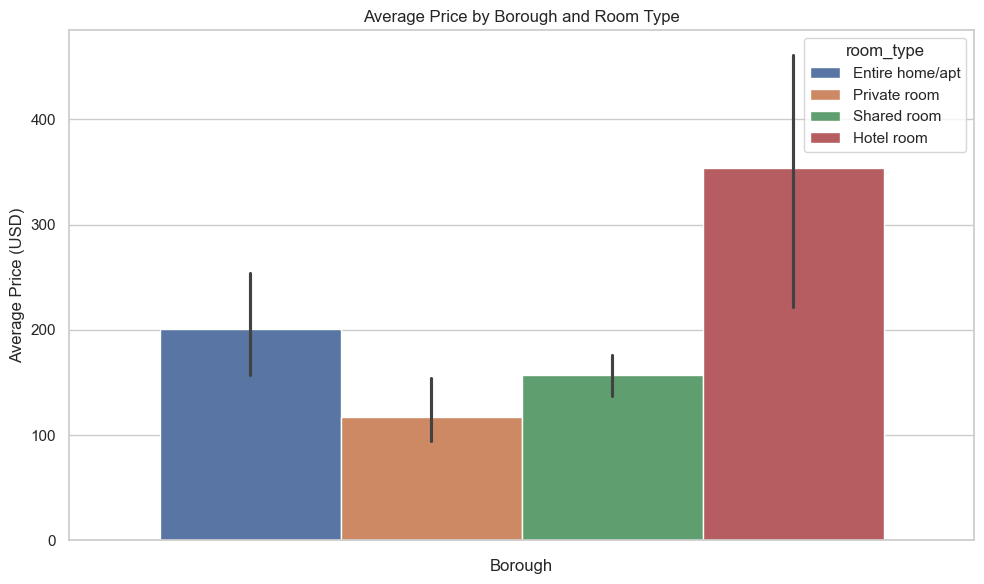

In [55]:
# Borough-level price summary statistics
if "neighbourhood_group_cleansed" in df.columns:
    borough_summary = (
        df.groupby("neighbourhood_group_cleansed")["price"]
        .agg(["count", "mean", "median", "std"])
        .sort_values("median")
    )

    print("Borough-level price summary:")
    print(borough_summary)
#Graph average price by borough and room type
    if {"neighbourhood_group_cleansed", "room_type"}.issubset(df.columns):
        avg_price = (
            df.groupby(["neighbourhood_group_cleansed", "room_type"])["price"]
            .mean()
            .reset_index()
        )
        plt.figure(figsize=(10,6))
        sns.barplot(
        data=avg_price, 
        y = "price",
        hue="room_type"
        )
        plt.title("Average Price by Borough and Room Type")
        plt.xlabel("Borough")
        plt.ylabel("Average Price (USD)")
        plt.tight_layout()
        plt.show()


In [57]:
# Prepare data for modeling
TARGET_COL = "price"
# Identify numeric and categorical features
numeric_features = [
    "accommodates",
    "bathrooms",
    "bedrooms",
    "beds",
    "minimum_nights",
    "maximum_nights",
    "availability_30",
    "availability_60",
    "availability_90",
    "availability_365",
    "number_of_reviews",
    "number_of_reviews_ltm",
    "number_of_reviews_l30d",
    "review_scores_rating",
    "review_scores_accuracy",
    "review_scores_cleanliness",
    "review_scores_checkin",
    "review_scores_communication",
    "review_scores_location",
    "review_scores_value",
    "amenities_count",
    "host_tenure_days",
    "name_len",
    "description_len",
    "neighborhood_overview_len"
]

numeric_features = [col for col in numeric_features if col in df.columns]

categorical_features = [
    "neighbourhood_group_cleansed",
    "neighbourhood_cleansed",
    "room_type",
    "property_type",
    "host_is_superhost",
    "host_has_profile_pic",
    "host_identity_verified",
    "has_availability",
    "instant_bookable"
]
categorical_features = [col for col in categorical_features if col in df.columns]

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

# Prepare X and y for modeling
feature_cols = numeric_features + categorical_features
# Ensure all feature columns exist in df
df_model = df[feature_cols + [TARGET_COL]].copy()
df_model = df_model.dropna(subset=[TARGET_COL])  # ensure target is present

X = df_model[feature_cols]
y = df_model[TARGET_COL]

print("X shape:", X.shape)
print("y shape:", y.shape)


Numeric features: ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'amenities_count', 'host_tenure_days', 'name_len', 'description_len', 'neighborhood_overview_len']
Categorical features: ['neighbourhood_group_cleansed', 'neighbourhood_cleansed', 'room_type', 'property_type', 'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'has_availability', 'instant_bookable']
X shape: (20477, 34)
y shape: (20477,)


In [58]:
# Split data into train, validation, and test sets (60/20/20)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42
)  # 0.25 of 0.8 = 0.2, so 60/20/20 overall

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)


Train shape: (12285, 34)
Validation shape: (4096, 34)
Test shape: (4096, 34)


In [59]:
# Preprocessing pipelines
# Numeric pipeline: impute missing with median, then scale
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
# Categorical pipeline: impute missing with most frequent, then one-hot encode
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])
# Combine into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


In [60]:
# Baseline model: Linear Regression
baseline_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LinearRegression())
])

baseline_model.fit(X_train, y_train)
# Predict on validation set
y_val_pred_baseline = baseline_model.predict(X_val)

def regression_metrics(y_true, y_pred, label=""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"=== {label} ===")
    print(f"MAE:  {mae:,.2f}")
    print(f"RMSE: {rmse:,.2f}")
    print(f"R^2:  {r2:,.4f}")

regression_metrics(y_val, y_val_pred_baseline, label="Baseline Linear Regression (validation)")


=== Baseline Linear Regression (validation) ===
MAE:  74.90
RMSE: 106.67
R^2:  0.5650


In [61]:
# Random Forest Regressor with Hyperparameter Tuning
rf_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestRegressor(random_state=42, n_jobs=-1))
])
# Hyperparameter grid for RF
rf_param_grid = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [10, 20, None],
    "model__min_samples_split": [2, 5],
    "model__min_samples_leaf": [1, 2]
}
# Grid search for RF
rf_grid = GridSearchCV(
    rf_pipeline,
    rf_param_grid,
    cv=3,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train, y_train)

print("Best RF params:", rf_grid.best_params_)

y_val_pred_rf = rf_grid.predict(X_val)
regression_metrics(y_val, y_val_pred_rf, label="Random Forest (best, validation)")


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best RF params: {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 200}
=== Random Forest (best, validation) ===
MAE:  50.86
RMSE: 85.20
R^2:  0.7225


In [62]:
# Gradient Boosting Regressor with Hyperparameter Tuning
gbr_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", GradientBoostingRegressor(random_state=42))
])
# Hyperparameter grid for GBR
gbr_param_grid = {
    "model__n_estimators": [100, 200],
    "model__learning_rate": [0.05, 0.1],
    "model__max_depth": [3, 4],
    "model__subsample": [0.8, 1.0]
}
# Grid search for GBR
gbr_grid = GridSearchCV(
    gbr_pipeline,
    gbr_param_grid,
    cv=3,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=1
)

gbr_grid.fit(X_train, y_train)

print("Best GBR params:", gbr_grid.best_params_)

y_val_pred_gbr = gbr_grid.predict(X_val)
regression_metrics(y_val, y_val_pred_gbr, label="Gradient Boosting (best, validation)")


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best GBR params: {'model__learning_rate': 0.1, 'model__max_depth': 4, 'model__n_estimators': 200, 'model__subsample': 0.8}
=== Gradient Boosting (best, validation) ===
MAE:  53.54
RMSE: 84.74
R^2:  0.7255


In [63]:
# Compare models on validation set
baseline_mae = mean_absolute_error(y_val, y_val_pred_baseline)
rf_mae = mean_absolute_error(y_val, y_val_pred_rf)
gbr_mae = mean_absolute_error(y_val, y_val_pred_gbr)

print("Baseline MAE:", baseline_mae)
print("RF MAE:", rf_mae)
print("GBR MAE:", gbr_mae)

# Pick the best (lowest MAE)
mae_dict = {"baseline": baseline_mae, "rf": rf_mae, "gbr": gbr_mae}
best_model_name = min(mae_dict, key=mae_dict.get)
print("\nBest model on validation:", best_model_name)
#assign best model
if best_model_name == "baseline":
    best_model = baseline_model
elif best_model_name == "rf":
    best_model = rf_grid.best_estimator_
else:
    best_model = gbr_grid.best_estimator_
#use best model to predict on test set
y_test_pred = best_model.predict(X_test)
regression_metrics(y_test, y_test_pred, label=f"{best_model_name.upper()} (test)")


Baseline MAE: 74.89661658069114
RF MAE: 50.857431466238836
GBR MAE: 53.54391157184577

Best model on validation: rf
=== RF (test) ===
MAE:  51.00
RMSE: 81.41
R^2:  0.7332


len(feature_names): 34
X_val.shape[1]: 34
Top 25 important features:


,feature,importance_mean,importance_std
27,room_type,0.332959,0.011704
25,neighbourhood_group_cleansed,0.197173,0.003753
1,bathrooms,0.141248,0.008250
4,minimum_nights,0.116261,0.005283
28,property_type,0.076789,0.004761
21,host_tenure_days,0.068798,0.004510
0,accommodates,0.056191,0.004171
20,amenities_count,0.042169,0.003903
26,neighbourhood_cleansed,0.034200,0.001621
10,number_of_reviews,0.033198,0.002295


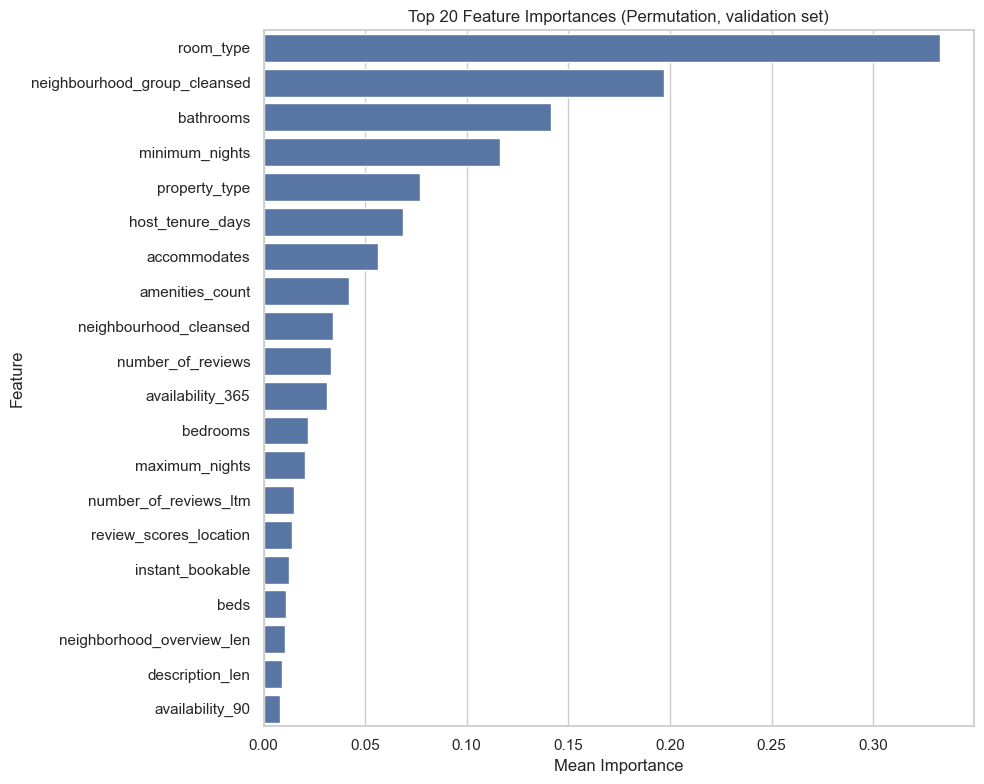

In [64]:
from sklearn.inspection import permutation_importance

# Only do feature importance for tree-based models
if best_model_name in ["rf", "gbr"]:
    # Use original feature names (one per column in X)
    feature_names = numeric_features + categorical_features

    # Sanity check: should match number of columns in X_val
    print("len(feature_names):", len(feature_names))
    print("X_val.shape[1]:", X_val.shape[1])

    # Permutation importance on validation set
    result = permutation_importance(
        best_model,
        X_val,
        y_val,
        n_repeats=5,
        random_state=42,
        n_jobs=-1
    )

    # Now all arrays have the same length
    importance_df = pd.DataFrame({
        "feature": feature_names,
        "importance_mean": result.importances_mean,
        "importance_std": result.importances_std
    }).sort_values("importance_mean", ascending=False)

    print("Top 25 important features:")
    display(importance_df.head(25))

    plt.figure(figsize=(10, 8))
    sns.barplot(
        data=importance_df.head(20),
        x="importance_mean",
        y="feature"
    )
    plt.title("Top 20 Feature Importances (Permutation, validation set)")
    plt.xlabel("Mean Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()
else:
    print("Best model is not tree-based; skipping feature importance.")


Borough true vs predicted mean prices and median errors:
                               true_mean   pred_mean  count
neighbourhood_group_cleansed                               
Bronx                         116.744099  126.708596    805
Staten Island                 119.104918  136.649213    305
Queens                        133.155008  136.701572   3245
Brooklyn                      165.028298  164.362898   7315
Manhattan                     270.779494  269.597053   8807


<Figure size 1200x600 with 0 Axes>

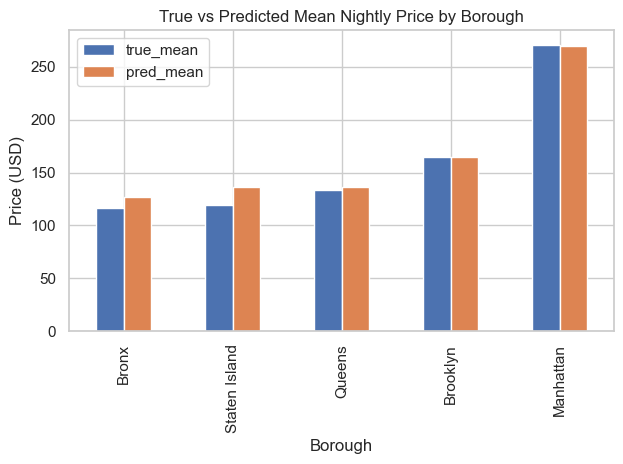

In [73]:
#Borough-level evaluation of predictions
if "neighbourhood_group_cleansed" in df.columns:
    X_all = X.copy()
    y_all = y.copy()
    mask_borough = X_all["neighbourhood_group_cleansed"].notna()
    X_b = X_all[mask_borough]

    preds_b = best_model.predict(X_b)
    tmp = X_b.copy()
    tmp["y_true"] = y_all[mask_borough]
    tmp["y_pred"] = preds_b

    borough_eval = tmp.groupby("neighbourhood_group_cleansed").agg(
        true_mean=("y_true", "mean"),
        pred_mean=("y_pred", "mean"),
        count=("y_true", "count"),
    ).sort_values("true_mean")

    print("Borough true vs predicted mean prices and median errors:")
    print(borough_eval)

    # Plot means and medians for comparison
    plt.figure(figsize=(12, 6))
    borough_eval[["true_mean", "pred_mean"]].plot(kind="bar")
    plt.title("True vs Predicted Mean Nightly Price by Borough")
    plt.xlabel("Borough")
    plt.ylabel("Price (USD)")
    plt.tight_layout()
    plt.show()

In [66]:
# Cell 20: Save final model + preprocessing pipeline to disk

MODEL_PATH = "nyc_airbnb_price_model.joblib"
joblib.dump(best_model, MODEL_PATH)

print(f"Saved best model ({best_model_name}) to {MODEL_PATH}")


Saved best model (rf) to nyc_airbnb_price_model.joblib


In [67]:
import numpy as np
import pandas as pd

# ================================
# 1. Safety checks
# ================================
model = best_model
if "model" not in globals():
    raise RuntimeError("No variable named 'model' found. Run the cell that trains/loads your model first.")

if "X" not in globals():
    raise RuntimeError("No variable named 'X' found. Make sure your feature matrix is defined as X.")

if "df" not in globals():
    raise RuntimeError("No DataFrame named 'df' found. Make sure df contains your Airbnb listings.")

# ================================
# 2. Align df with X and ensure numeric price
# ================================
# X usually contains a subset of rows/columns from df; align on index just in case.
common_index = X.index.intersection(df.index)
X_for_pred = X.loc[common_index]
df_for_pred = df.loc[common_index].copy()

# Ensure price is numeric (in case it was still a string like "$123.00")
df_for_pred["price_numeric"] = pd.to_numeric(df_for_pred["price"], errors="coerce")

# Drop rows without a usable price
df_for_pred = df_for_pred.dropna(subset=["price_numeric"])

# Align X again in case some rows were dropped
X_for_pred = X_for_pred.loc[df_for_pred.index]

# ================================
# 3. Use YOUR ML MODEL to predict expected price
# ================================
df_for_pred["predicted_price"] = model.predict(X_for_pred)

# ================================
# 4. Compute difference and percentage difference
# ================================
df_for_pred["price_diff"] = df_for_pred["price_numeric"] - df_for_pred["predicted_price"]
df_for_pred["price_diff_pct"] = df_for_pred["price_diff"] / df_for_pred["predicted_price"]

# Example: a value of -0.20 means 20% cheaper than the model thinks it "should" be.

# ================================
# 5. Turn that into an AutoTrader-style rating
# ================================
# You can tweak these thresholds to be stricter or looser.
bins = [-np.inf, -0.20, -0.10, 0.10, 0.25, np.inf]
labels = [
    "Great deal",   # >= 20% below expected
    "Good deal",    # 10–20% below
    "Fair price",   # within ±10%
    "A bit high",   # 10–25% above
    "Overpriced"    # >25% above expected
]

df_for_pred["price_rating"] = pd.cut(df_for_pred["price_diff_pct"], bins=bins, labels=labels)

# ================================
# 6. (Optional) also look at how this compares within the area
# ================================
# This uses the residuals (price_diff_pct) within each neighbourhood_group_cleansed
# so you can see how "expensive for the area" it is, on top of the ML model.
if "neighbourhood_group_cleansed" in df_for_pred.columns:
    df_for_pred["area_residual_z"] = (
        df_for_pred.groupby("neighbourhood_group_cleansed")["price_diff_pct"]
        .transform(lambda x: (x - x.mean()) / x.std(ddof=0))
    )
    # Rough interpretation:
    #   - z <= -1.0 : cheaper than typical in its area
    #   - z around 0 : typical for its area
    #   - z >=  1.0 : more expensive than typical in its area

# ================================
# 7. Inspect some results
# ================================
cols_to_show = [
    "id",
    "neighbourhood_group_cleansed" if "neighbourhood_group_cleansed" in df_for_pred.columns else None,
    "neighbourhood_cleansed" if "neighbourhood_cleansed" in df_for_pred.columns else None,
    "price_numeric",
    "predicted_price",
    "price_diff_pct",
    "price_rating",
    "minimum_nights"
]
cols_to_show = [c for c in cols_to_show if c is not None]

print("Sample of listings with ML-based value rating:\n")
display(df_for_pred[cols_to_show].head(100))

# Also keep the full rated DataFrame for further analysis
df_with_price_ratings = df_for_pred

Sample of listings with ML-based value rating:



,id,neighbourhood_group_cleansed,neighbourhood_cleansed,price_numeric,predicted_price,price_diff_pct,price_rating,minimum_nights
0,40824219,Queens,Sunnyside,66.0,66.365,-0.005500,Fair price,30
4,40839416,Manhattan,East Village,76.0,85.090,-0.106828,Good deal,30
5,40843980,Queens,Ozone Park,97.0,149.570,-0.351474,Great deal,30
7,40824301,Brooklyn,Williamsburg,60.0,108.585,-0.447437,Great deal,30
8,40825740,Brooklyn,Crown Heights,425.0,423.135,0.004408,Fair price,30
...,...,...,...,...,...,...,...,...
167,98663,Manhattan,Chelsea,150.0,155.050,-0.032570,Fair price,30
168,100002,Manhattan,Washington Heights,62.0,144.360,-0.570518,Great deal,30
169,100186,Brooklyn,Gowanus,150.0,158.105,-0.051263,Fair price,30
173,176135,Brooklyn,Crown Heights,101.0,108.910,-0.072629,Fair price,30


In [68]:
import numpy as np
import pandas as pd

# ==========================================
# ML-based "deal" rating for each listing
# ==========================================

# We assume these already exist from earlier cells:
# - df: original Airbnb dataframe
# - best_model: your trained ML model
# - feature_cols: list of feature columns used to train the model
# - TARGET_COL: name of the price column (e.g., "price")

# 1. Build DataFrame for prediction
df_for_pred = df.copy()

# Keep only rows where all features are available
df_for_pred = df_for_pred.dropna(subset=feature_cols + [TARGET_COL])

# Features and target for prediction
X_for_pred = df_for_pred[feature_cols]
df_for_pred["price_numeric"] = df_for_pred[TARGET_COL].astype(float)

# 2. Predict expected price with your model
df_for_pred["predicted_price"] = best_model.predict(X_for_pred)

# 3. Compute difference and percentage difference
df_for_pred["price_diff"] = df_for_pred["price_numeric"] - df_for_pred["predicted_price"]
df_for_pred["price_diff_pct"] = df_for_pred["price_diff"] / df_for_pred["predicted_price"]

# 4. Turn percentage difference into an AutoTrader-style rating
def rate_listing(pct_diff):
    """
    pct_diff = (actual - predicted) / predicted
    negative = cheaper than expected, positive = more expensive than expected
    """
    if pct_diff <= -0.20:
        return "Great deal"
    elif pct_diff <= -0.10:
        return "Good deal"
    elif pct_diff <= 0.10:
        return "Fair price"
    elif pct_diff <= 0.25:
        return "Slightly overpriced"
    else:
        return "Overpriced"

df_for_pred["price_rating"] = df_for_pred["price_diff_pct"].apply(rate_listing)

# Save full rated DataFrame for later use
df_with_price_ratings = df_for_pred

# ==============
# Clean outputs
# ==============
print("ML-based value rating for Airbnb listings")
print("========================================\n")

# Overall distribution of ratings
rating_counts = (
    df_with_price_ratings["price_rating"]
    .value_counts()
    .rename("count")
    .to_frame()
)
rating_counts["percent"] = (rating_counts["count"] / len(df_with_price_ratings) * 100).round(1)

display(rating_counts)

# Show a small sample table to talk through in the presentation
cols_to_show = []

for c in ["id", "neighbourhood_group_cleansed", "neighbourhood_cleansed",
          "room_type", "price_numeric", "predicted_price",
          "price_diff_pct", "price_rating"]:
    if c in df_with_price_ratings.columns:
        cols_to_show.append(c)

sample = (
    df_with_price_ratings[cols_to_show]
    .sample(10, random_state=42)  # random but reproducible sample
    .sort_values("price_diff_pct")
)

display(
    sample.style.format({
        "price_numeric": "${:,.0f}".format,
        "predicted_price": "${:,.0f}".format,
        "price_diff_pct": "{:+.0%}".format
    })
)

ML-based value rating for Airbnb listings



,count,percent
price_rating,,
Fair price,6713,47.6
Great deal,2529,17.9
Good deal,2410,17.1
Slightly overpriced,1457,10.3
Overpriced,996,7.1


,id,neighbourhood_group_cleansed,neighbourhood_cleansed,room_type,price_numeric,predicted_price,price_diff_pct,price_rating
22298,720734674577622946,Staten Island,Stapleton,Entire home/apt,$140,$194,-28%,Great deal
5101,10253159,Staten Island,Castleton Corners,Entire home/apt,$204,$256,-20%,Great deal
14110,39199781,Manhattan,Chinatown,Private room,$74,$85,-13%,Good deal
20668,618994191723179959,Queens,South Ozone Park,Private room,$136,$150,-9%,Fair price
7784,18268053,Queens,Woodside,Private room,$42,$45,-6%,Fair price
27029,970497589664733128,Brooklyn,Canarsie,Entire home/apt,$163,$170,-4%,Fair price
370,397034,Manhattan,Upper West Side,Private room,$127,$126,+1%,Fair price
25611,884717759824402312,Brooklyn,Bedford-Stuyvesant,Private room,$186,$177,+5%,Fair price
23068,760808327741861820,Queens,Elmhurst,Private room,$70,$61,+14%,Slightly overpriced
31463,1213364464605802277,Brooklyn,Williamsburg,Entire home/apt,$238,$201,+18%,Slightly overpriced
